# COVID19 - Building a model from the clinical data

In this notebook I will unify, explore and clean the clinical data in this repository. After that I will try to build a model to predict whether the coronavirus test will be positive or negative, ie, clinically diagnose COVID19

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import glob
import os

os.chdir('covidclinicaldata/data/') # Change the working directory to the data directory
all_data_available = glob.glob('*.csv')
print(all_data_available)

['04-07_carbonhealth_and_braidhealth.csv', '04-14_carbonhealth_and_braidhealth.csv', '04-21_carbonhealth_and_braidhealth.csv', '04-28_carbonhealth_and_braidhealth.csv', '05-05_carbonhealth_and_braidhealth.csv', '05-12_carbonhealth_and_braidhealth.csv', '05-19_carbonhealth_and_braidhealth.csv', '05-26_carbonhealth_and_braidhealth.csv', '06-02_carbonhealth_and_braidhealth.csv', '06-09_carbonhealth_and_braidhealth.csv', '06-16_carbonhealth_and_braidhealth.csv', '06-23_carbonhealth_and_braidhealth.csv', '06-30_carbonhealth_and_braidhealth.csv', '07-07_carbonhealth_and_braidhealth.csv', '07-14_carbonhealth_and_braidhealth.csv', '07-21_carbonhealth_and_braidhealth.csv', '07-28_carbonhealth_and_braidhealth.csv', '08-04_carbonhealth_and_braidhealth.csv', '08-11_carbonhealth_and_braidhealth.csv', '08-18_carbonhealth_and_braidhealth.csv', '08-25_carbonhealth_and_braidhealth.csv', '09-01_carbonhealth_and_braidhealth.csv', '09-08_carbonhealth_and_braidhealth.csv', '09-15_carbonhealth_and_braidheal

In [62]:
# We load all data from the repo

all_data = None #A workaround to declare the all_data variable for use later

for file in all_data_available:     
    df = pd.read_csv("../data/" + file)    
    print(file, df["covid19_test_results"].value_counts()["Positive"] / len(df["covid19_test_results"]), "Size:", len(df))
    try:
        df["rapid_flu_results"] = df["rapid_flu_results"].astype("object") #Because in 2 files all values are null and because of that pandas changes the column type to float
        if all_data is None:
            all_data = df
        else:
            
            all_data = pd.merge(all_data, df, how="outer")

    except Exception as e:
        print(file, "could not be merged:", e)
        print(len(df), "rows were left out")

    print("All data size:", len(all_data))

04-07_carbonhealth_and_braidhealth.csv 0.061224489795918366 Size: 735
All data size: 735
04-14_carbonhealth_and_braidhealth.csv 0.08365019011406843 Size: 263
All data size: 998
04-21_carbonhealth_and_braidhealth.csv 0.03074141048824593 Size: 1106
All data size: 2104
04-28_carbonhealth_and_braidhealth.csv 0.011996572407883462 Size: 1167
All data size: 3271
05-05_carbonhealth_and_braidhealth.csv 0.018738288569643973 Size: 1601
All data size: 4872
05-12_carbonhealth_and_braidhealth.csv 0.03541315345699832 Size: 593
All data size: 5465
05-19_carbonhealth_and_braidhealth.csv 0.05353319057815846 Size: 934
All data size: 6399
05-26_carbonhealth_and_braidhealth.csv 0.04533333333333334 Size: 750
All data size: 7149
06-02_carbonhealth_and_braidhealth.csv 0.03134479271991911 Size: 989
All data size: 8138
06-09_carbonhealth_and_braidhealth.csv 0.010725552050473186 Size: 1585
All data size: 9723
06-16_carbonhealth_and_braidhealth.csv 0.011756569847856155 Size: 1446
All data size: 11169
06-23_carbon

In [63]:
#All Data info
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93995 entries, 0 to 93994
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   batch_date                     93995 non-null  object 
 1   test_name                      93995 non-null  object 
 2   swab_type                      93995 non-null  object 
 3   covid19_test_results           93995 non-null  object 
 4   age                            93995 non-null  int64  
 5   high_risk_exposure_occupation  93826 non-null  object 
 6   high_risk_interactions         69168 non-null  object 
 7   diabetes                       93995 non-null  object 
 8   chd                            93995 non-null  object 
 9   htn                            93995 non-null  object 
 10  cancer                         93995 non-null  object 
 11  asthma                         93995 non-null  object 
 12  copd                           93995 non-null 

In [64]:
#The total rate of positive values in all the dataset
all_data["covid19_test_results"].value_counts()["Positive"] / len(all_data["covid19_test_results"])

0.013968828129155807

In [65]:
print(len(all_data))
print(all_data.index.nunique())
print(all_data.drop_duplicates().shape)
all_data.covid19_test_results.value_counts()


93995
93995
(62342, 46)


Negative    92682
Positive     1313
Name: covid19_test_results, dtype: int64

### Removing columns with almost no info

The first ones that come to mind to <u>remove</u> are the <u>rapid flu and rapid strep</u> results, since they are less than 1 percent of the data (both positive and negative). I will also <u>get rid of the the radiological findings (features with <i>cxr_</i> prefix)</u>, since they are too few as well.

After that, I am somewhat suspicious of the <u>cough severity</u> and <u>shortness of breath (sob) severity</u>, since it is my intuition that the severity is dependant on whether they have cough or sob. I'll check that in the cell after dropping, and if that is the case, I will <u>join those columns so a value of 0 means no cough or sob following numbers from 1-N depending on the severity values</u>.

I was hesitant to check the <u>er_referral</u> (whether the patient was referred to ER or not) but since the goal is to build an online predictor for the covid test, we don't need it and it <u>will be removed from the data</u>.

In [66]:
all_data.drop(columns=["batch_date", "test_name", "swab_type", "er_referral"], inplace=True) #Dropping the columns that have nothing to do with the information about the disease itself

In [67]:
columns_to_drop = ["rapid_flu_results", "rapid_strep_results", "cxr_findings", "cxr_impression", "cxr_label", "cxr_link"]
all_data.drop(columns=columns_to_drop, inplace = True)

<b>Cough and cough severity</b>

In [68]:
print(all_data["cough"].value_counts())
print("Not nan values:", all_data["cough_severity"].notna().sum())
print(" ")
print("All that have a cough and have cough severity")
print(all_data[(all_data["cough"].notna()) & (all_data["cough"] == True)]["cough_severity"].value_counts())
print("All that do not have a cough and have cough severity")
print(all_data[(all_data["cough"].notna()) & (all_data["cough"] == False)]["cough_severity"].value_counts()) #The cough value for this one is going to be changed to true
print("All that have cough as nan and have cough severity")
print(all_data[(all_data["cough"].isna())].loc[:,"cough_severity"].value_counts()) #This is empty so it is correct
print("Number of rows with cough and no cough severity: ", len(all_data[(all_data["cough"] == True) & (all_data["cough_severity"].isna())])) #Since this are just 15 they are to be imputated with the most frequent type

False    88135
True      5845
Name: cough, dtype: int64
Not nan values: 5711
 
All that have a cough and have cough severity
Mild        3443
Moderate    1510
Severe       111
Name: cough_severity, dtype: int64
All that do not have a cough and have cough severity
Mild        523
Moderate    117
Severe        7
Name: cough_severity, dtype: int64
All that have cough as nan and have cough severity
Series([], Name: cough_severity, dtype: int64)
Number of rows with cough and no cough severity:  781


In [69]:
cough_false_severity_not_na = all_data.loc[((all_data["cough"].isna()) | (all_data["cough"] == False)) & (all_data["cough_severity"].notna())].index
all_data.loc[cough_false_severity_not_na, "cough"] = True

all_data.loc[(all_data["cough"] == True) & (all_data["cough_severity"].isna()), "cough_severity"] = all_data["cough_severity"].mode()[0] #Since it returns a series, the 0 subscript is to retrieve the value

<b>SOB (shortedness of breath) and SOB severity</b>

In [70]:
print(all_data["sob"].value_counts())
print("Not nan values:", all_data["sob_severity"].notna().sum())
print(" ")
print("All that have sob and have sob severity")
print(all_data[(all_data["sob"].notna()) & (all_data["sob"] == True)]["sob_severity"].value_counts())
print("All that do not have sob and have sob severity")
print(all_data[(all_data["sob"].notna()) & (all_data["sob"] == False)]["sob_severity"].value_counts()) #The cough value for this one is going to be changed to true
print("All that have sob as nan and have sob severity")
print(all_data[(all_data["sob"].isna())].loc[:,"sob_severity"].value_counts()) #This is empty so it is correct
print("Number of rows with sob and no sob severity: ", len(all_data[(all_data["sob"] == True) & (all_data["sob_severity"].isna())])) #Since this are just 15 they are to be imputated with the most frequent type

False    90947
True      2842
Name: sob, dtype: int64
Not nan values: 2836
 
All that have sob and have sob severity
Mild        1274
Moderate     959
Severe       117
Name: sob_severity, dtype: int64
All that do not have sob and have sob severity
Mild        330
Moderate    147
Severe        9
Name: sob_severity, dtype: int64
All that have sob as nan and have sob severity
Series([], Name: sob_severity, dtype: int64)
Number of rows with sob and no sob severity:  492


In [71]:
sob_false_severity_not_na = all_data.loc[((all_data["sob"].isna()) | (all_data["sob"] == False)) & (all_data["sob_severity"].notna())].index
all_data.loc[sob_false_severity_not_na, "sob"] = True

all_data.loc[(all_data["sob"] == True) & (all_data["sob_severity"].isna()), "sob_severity"] = all_data["sob_severity"].mode()[0] #Since it returns a series, the 0 subscript is to retrieve the value

In [72]:
all_data.loc[(all_data["sob"] == False) & (all_data["sob_severity"].isna()), "sob_severity"] = "None"

## Exploring positive and negative values

In this section I will see if there is a value that is only found in negative and/or positive examples. To do that, I will separate the data into the positive and negative datasets and check the information regarding null values and unique values (for this last part I will substract the number of unique values in all_data from the number of unique values in each class).

Let's start with the positives first:

In [73]:
#Positive data info
positive_data = all_data[all_data["covid19_test_results"] == "Positive"]
positive_data.info()
all_data.nunique() - positive_data.nunique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1313 entries, 21 to 93813
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   covid19_test_results           1313 non-null   object 
 1   age                            1313 non-null   int64  
 2   high_risk_exposure_occupation  1308 non-null   object 
 3   high_risk_interactions         1078 non-null   object 
 4   diabetes                       1313 non-null   object 
 5   chd                            1313 non-null   object 
 6   htn                            1313 non-null   object 
 7   cancer                         1313 non-null   object 
 8   asthma                         1313 non-null   object 
 9   copd                           1313 non-null   object 
 10  autoimmune_dis                 1313 non-null   object 
 11  smoker                         1313 non-null   object 
 12  temperature                    1071 non-null  

covid19_test_results              1
age                              13
high_risk_exposure_occupation     0
high_risk_interactions            0
diabetes                          0
chd                               0
htn                               0
cancer                            0
asthma                            0
copd                              1
autoimmune_dis                    0
smoker                            0
temperature                      36
pulse                            35
sys                              24
dia                              32
rr                               12
sats                             11
ctab                              0
labored_respiration               0
rhonchi                           0
wheezes                           0
days_since_symptom_onset          7
cough                             0
cough_severity                    0
fever                             0
sob                               0
sob_severity                

Here we can see there are some features that have less values in the positive dataste than in all the data (not counting the continuous values for the vitals). These features are COPD (Chronic Obstructive Pulmonary Disease)and sob severity. Let's explore this values

In [74]:
print("all_data:")
print(all_data["copd"].value_counts())
print(all_data["sob_severity"].value_counts())
print("positive_data:")
print(positive_data["copd"].value_counts())
print(positive_data["sob_severity"].value_counts())

all_data:
False    93943
True        52
Name: copd, dtype: int64
None        90461
Mild         2096
Moderate     1106
Severe        126
Name: sob_severity, dtype: int64
positive_data:
False    1313
Name: copd, dtype: int64
None        1188
Mild          84
Moderate      36
Name: sob_severity, dtype: int64


It seems that having a <u>copd</u> would be a good indicator of NOT having Covid19, which doesn't sound right. Given that there are only 52 cases with copd in the whole dataset, it sounds like we just simply don't have enough data on positive cases to determine whether this would be a useful feature or not (we prefer a lot of false positives, so a variable whose prescence indicates a negative result is not to be desired). Also if we see what is the proportion of True and False (52/93943) cases in all data, the similar proportion for positive data would be not even one case (0.726 patients would need to exist with copd and positive result) so it is very likely we just dont have positive patients with copd because the sample isn't big enough, making the feature irrelevant. Because of that I have decided to <u>remove the feature from the dataset</u>. <br>
<i>Note: I might leave it for just one experiment to see how much it affects the performance of the classifier. I guess it will actually separate nicely</i>
<br>
<br>
As for the <u>sob severity</u>, it seems very similar to the previous result: having a severe condition implies that there is a higher chance of being negative, which seems counter-intuitive from what we know about Covid19. Furthermore, looking at the numbers we can see that since in the whole dataset there are only 126 people with a severe shortness of breath I would bet that the lack of severity in positive patients is just due to not having enough data. In this case, however, I would be against dismissing the whole feature since I was planning to merge it with the indicator for sob. Since the patients with severe shortedness of breath represent just about 0.1% of the dataset, the best approach might be to just <u>dismiss all of the patients with severe shortedness of breath</u>. <b>I am still not sure this is the best course of action</b>.

In [75]:
#dropping the copd feature
all_data.drop(columns="copd", inplace=True)

sob_severe_indexes = all_data[all_data["sob_severity"] == "Severe"].index
all_data.drop(index=sob_severe_indexes, inplace=True)

Let's try the same analysis with the negatives:

In [76]:
#Negative data info
negative_data = all_data[all_data["covid19_test_results"] == "Negative"]
negative_data.info()
all_data.nunique() - negative_data.nunique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92556 entries, 0 to 93994
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   covid19_test_results           92556 non-null  object 
 1   age                            92556 non-null  int64  
 2   high_risk_exposure_occupation  92392 non-null  object 
 3   high_risk_interactions         67976 non-null  object 
 4   diabetes                       92556 non-null  object 
 5   chd                            92556 non-null  object 
 6   htn                            92556 non-null  object 
 7   cancer                         92556 non-null  object 
 8   asthma                         92556 non-null  object 
 9   autoimmune_dis                 92556 non-null  object 
 10  smoker                         92556 non-null  object 
 11  temperature                    46375 non-null  float64
 12  pulse                          47098 non-null 

covid19_test_results             1
age                              0
high_risk_exposure_occupation    0
high_risk_interactions           0
diabetes                         0
chd                              0
htn                              0
cancer                           0
asthma                           0
autoimmune_dis                   0
smoker                           0
temperature                      1
pulse                            0
sys                              0
dia                              0
rr                               0
sats                             0
ctab                             0
labored_respiration              0
rhonchi                          0
wheezes                          0
days_since_symptom_onset         0
cough                            0
cough_severity                   0
fever                            0
sob                              0
sob_severity                     0
diarrhea                         0
fatigue             

As we can see, there is only one different value in the negatives that does not exist in the positives, and that corresponds to a single value in temperature, which is a continuous variable that we will explore later. So, there will be no changes further in the data due to the negative tests.

The next part will be plotting the continuous features to see if there is any hole that could be useful for prediction.

In [77]:
all_data.describe() #After running the line we can see that initially we only have 8 continuous variables

,age,temperature,pulse,sys,dia,rr,sats,days_since_symptom_onset
count,93869.000000,47446.000000,48180.000000,46431.000000,46431.000000,41370.000000,47438.000000,15747.000000
mean,39.179026,36.794741,76.913885,123.152657,78.298012,14.709862,98.238564,7.056836
std,15.038488,0.289177,13.228319,16.115788,9.460495,1.971138,1.423834,17.263409
min,-3.000000,33.500000,35.000000,50.000000,15.000000,0.000000,55.000000,1.000000
25%,28.000000,36.650000,68.000000,112.000000,72.000000,13.000000,97.000000,2.000000
50%,37.000000,36.800000,76.000000,121.000000,78.000000,15.000000,98.000000,3.000000
75%,50.000000,36.950000,85.000000,132.000000,84.000000,16.000000,99.000000,5.000000
max,91.000000,39.600000,160.000000,235.000000,150.000000,40.000000,100.000000,300.000000


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

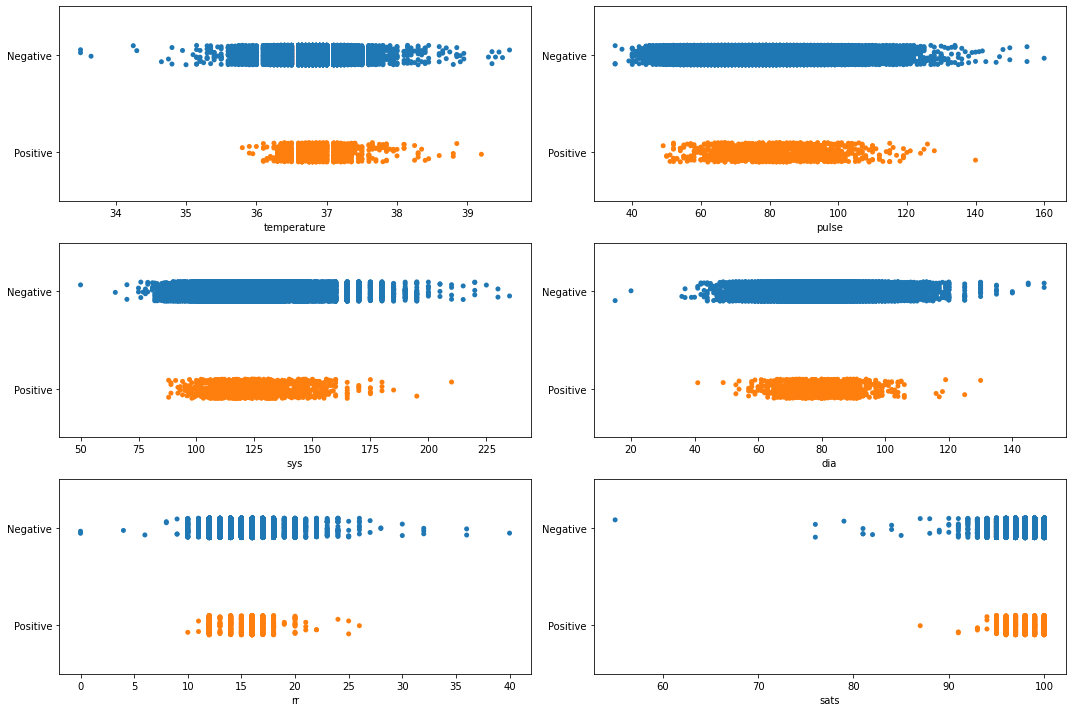

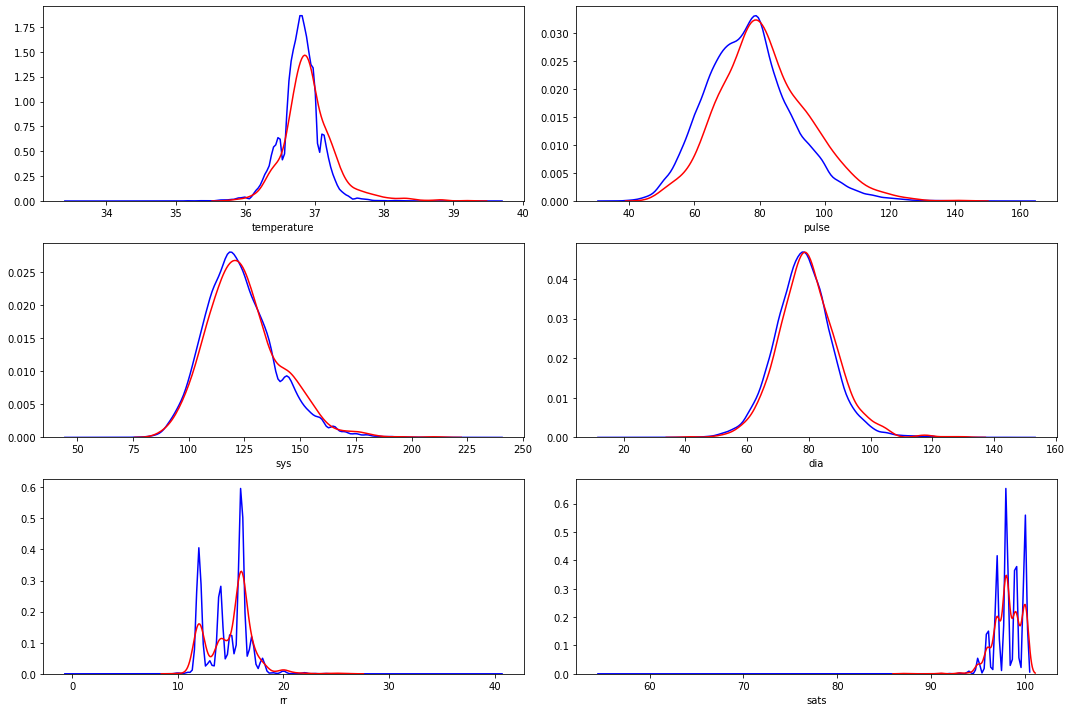

In [78]:
def plot_vitals():
    vitals = ["temperature", "pulse", "sys", "dia", "rr", "sats"]
    # 'f' is the figure (the container) where everything will be ploted. 
    # 'axes' is the array of subplots (called axes) where each subplot will be plotted (in this case an array of 3 rows and 2 columns)
    # Note: you cann add axes to figures to make them subplots
    f, axes = plt.subplots(3,2, figsize=(15,10)) 
    i = 0
    j = 0
    for feature in vitals:   
        sns.stripplot(data=all_data, x=feature, y="covid19_test_results", ax=axes[i % 3][j % 2])    #this returns an 'ax' object, which we are passing
        axes[i % 3][j % 2].set_ylabel('')
        j+=1
        if j%2 == 0:
            i+=1

    f.tight_layout()
    
    f2, axes2 = plt.subplots(3,2, figsize=(15,10)) 
    i = 0
    j = 0
    for feature in vitals:   
        sns.distplot(all_data.loc[all_data["covid19_test_results"] == "Negative", feature], ax=axes2[i % 3][j % 2], color="b", hist=False)    #this returns an 'ax' object, which we are passing
        sns.distplot(all_data.loc[all_data["covid19_test_results"] == "Positive", feature], ax=axes2[i % 3][j % 2], color="r", hist=False)    #this returns an 'ax' object, which we are passing
        axes2[i % 3][j % 2].set_ylabel('')
        j+=1
        if j%2 == 0:
            i+=1

    f2.tight_layout()

plot_vitals()

We can observe that for almost every continuous feature there are some data points that might be considered outliers and most of them are occurring within the negative result dataset. I will establish some boundaries depending on the feature (trying to include as many positive results as possible) for each feature and then I will count how many of points exist outside those boundaries. If there are enough significant points I will replace them with the minimum value. If the number is too low then I will just drop them<i>Note: I might use nearest k-nearest-neighbor imputation as a side experiment to see how it improves the performance of the algorithm.</i><br>


| Feature | Lower bound | Upper bound |
|:-|:-:|:-:|
| Temperature | 34.5 | 39 |
| Pulse | <b>N/A</b> | 150 |
| Sys | 62.5 | 225 |
| Dia | 30 | 140 |
| RR | 7.5 | 35 |
| Sats | 80 | <b>N/A</b>|

In [79]:
print("Temperature below 34.5°:")
low_temp = all_data[all_data["temperature"]<34.5]
print(low_temp.covid19_test_results.value_counts())
print("Temperature above 39°:")
high_temp = all_data[all_data["temperature"]>39]
print(all_data[all_data["temperature"]>39].covid19_test_results.value_counts())
print("Pulse above 150:")
hi_pulse = all_data[all_data["pulse"]>150]
print(all_data[all_data["pulse"]>150].covid19_test_results.value_counts())

print("Systolic below 75:")
low_sys = all_data[all_data["sys"]<75]
print(all_data[all_data["sys"]<75].covid19_test_results.value_counts())
print("Systolic above 225:")
high_sys = all_data[all_data["sys"]>225]
print(all_data[all_data["sys"]>225].covid19_test_results.value_counts())
print("Diastolic below 30:")
low_dia = all_data[all_data["dia"]<30]
print(all_data[all_data["dia"]<30].covid19_test_results.value_counts())
print("Diastolyc above 140:")
high_dia = all_data[all_data["dia"]>140]
print(all_data[all_data["dia"]>140].covid19_test_results.value_counts())
print("Respiratory rate below 7.5:")
low_rr = all_data[all_data["rr"]<7.5]
print(all_data[all_data["rr"]<7.5].covid19_test_results.value_counts())
print("Respiratory rate above 35:")
high_rr = all_data[all_data["rr"]>35]
print(all_data[all_data["rr"]>35].covid19_test_results.value_counts())
print("Saturation level below 80:")
low_sats = all_data[all_data["sats"]<80]
print(all_data[all_data["sats"]<80].covid19_test_results.value_counts())

Temperature below 34.5°:
Negative    5
Name: covid19_test_results, dtype: int64
Temperature above 39°:
Negative    7
Positive    1
Name: covid19_test_results, dtype: int64
Pulse above 150:
Negative    3
Name: covid19_test_results, dtype: int64
Systolic below 75:
Negative    4
Name: covid19_test_results, dtype: int64
Systolic above 225:
Negative    3
Name: covid19_test_results, dtype: int64
Diastolic below 30:
Negative    2
Name: covid19_test_results, dtype: int64
Diastolyc above 140:
Negative    4
Name: covid19_test_results, dtype: int64
Respiratory rate below 7.5:
Negative    4
Name: covid19_test_results, dtype: int64
Respiratory rate above 35:
Negative    3
Name: covid19_test_results, dtype: int64
Saturation level below 80:
Negative    4
Name: covid19_test_results, dtype: int64


We can see that all of the features have a very low number of outliers (given by the thresholds I was using) so I will choose to remove all of the defective points (except for temperature above 39° becaue on second thought, values above 39° are possible values). Also I would like to note that the above cell helped me notice that indeed a point in the graph is just a point in real data, so I have decided I will also trim the positive datapoints in a separate cutoff from the negatives

In [80]:
def calculate_union(df_list):
    union = df_list[0].index
    for df in df_list:
        union = np.union1d(union, df.index)
        
    return union

def calculate_intersection(df_list):
    intersection = df_list[0].index
    for df in df_list:
        intersection = np.intersect1d(intersection, df.index)
    return intersection


In [81]:
df_list =[low_temp, hi_pulse, low_sys, high_sys, low_dia, high_dia, low_rr, high_rr, low_sats]
union = calculate_union(df_list)
intersection = calculate_intersection(df_list)

all_data.drop(index=union, inplace=True)

In [82]:
df_list = [positive_data[positive_data["pulse"] >= 140], positive_data[positive_data["sys"] >= 190], positive_data[(positive_data["dia"] <= 50) | (positive_data["dia"] >= 110)]]
union = calculate_union(df_list)
instersection = calculate_intersection(df_list)

all_data.drop(index=union, inplace=True)

### After cleaning continuous values

C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

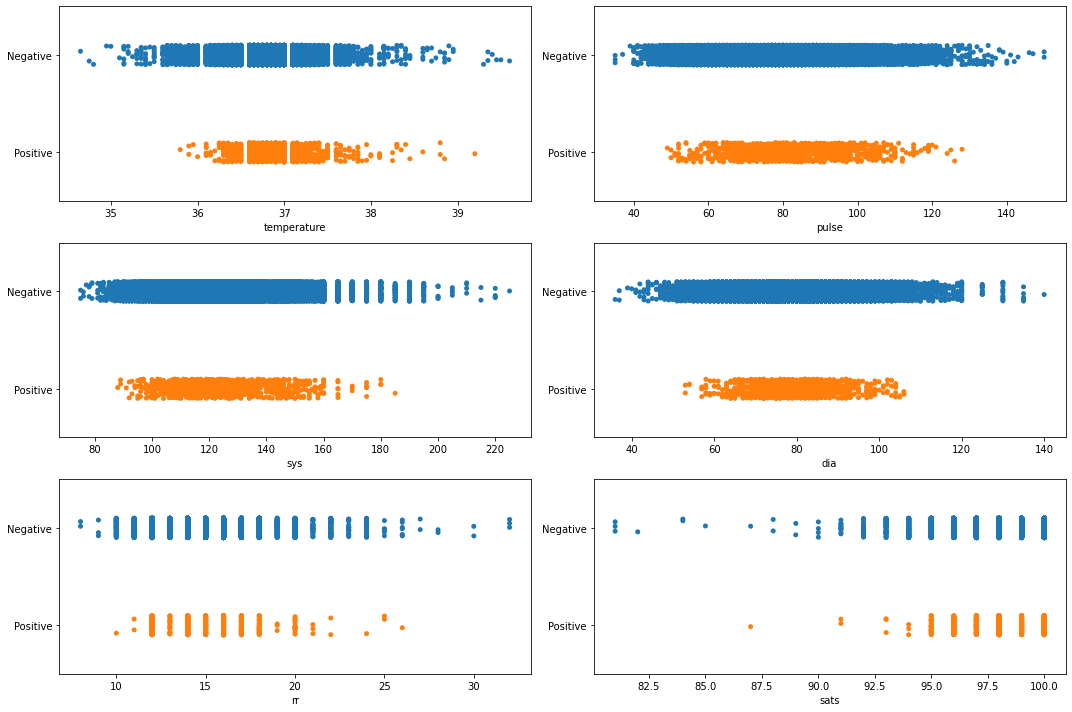

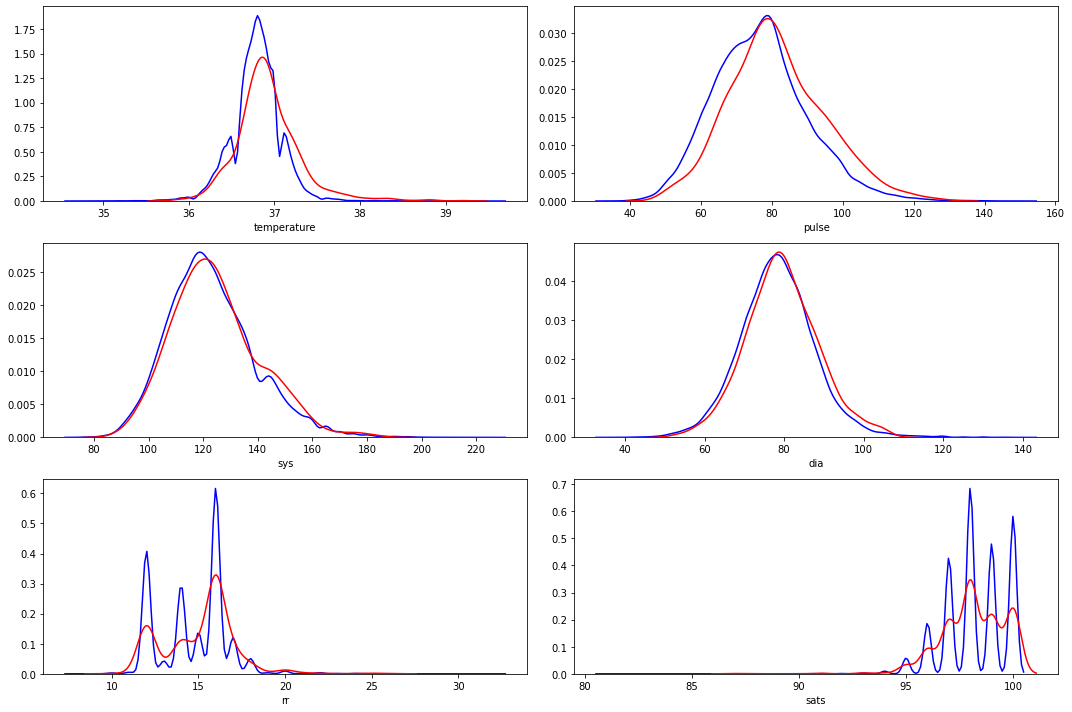

In [83]:
plot_vitals()

As the plot shows, there are still some outliers remaining. However the graphs are a bit tighter now, which will help us to infer where the bulk mass of the data is.


## Data imputation and separation in different datasets

In this part, having removed all columns that will not be used whether it is because of lack of information or because they do not provide any useful information per se, I will impute missing data for the values that have a relatively small missing portion of the data. I use the most frequent value in this type of column first. I might experiment with Imputation by most frequent neighbor

Next, for the others I will explore the option of separating them into different datasets or imputing the data.

In [25]:
#Lets see how many unique values each column has
#This will take the nans as an additional value. That's why .nunique is preferred
#for column in all_data.columns:
    #print(column, len(all_data[column].unique()), sep=": ") 

all_data.info()
all_data.nunique(axis=0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93829 entries, 0 to 93994
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   covid19_test_results           93829 non-null  object 
 1   age                            93829 non-null  int64  
 2   high_risk_exposure_occupation  93660 non-null  object 
 3   high_risk_interactions         69021 non-null  object 
 4   diabetes                       93829 non-null  object 
 5   chd                            93829 non-null  object 
 6   htn                            93829 non-null  object 
 7   cancer                         93829 non-null  object 
 8   asthma                         93829 non-null  object 
 9   autoimmune_dis                 93829 non-null  object 
 10  smoker                         93829 non-null  object 
 11  temperature                    47408 non-null  float64
 12  pulse                          48143 non-null 

covid19_test_results               2
age                               95
high_risk_exposure_occupation      2
high_risk_interactions             2
diabetes                           2
chd                                2
htn                                2
cancer                             2
asthma                             2
autoimmune_dis                     2
smoker                             2
temperature                       82
pulse                            110
sys                               98
dia                               88
rr                                23
sats                              18
ctab                               2
labored_respiration                2
rhonchi                            2
wheezes                            2
days_since_symptom_onset          20
cough                              2
cough_severity                     4
fever                              2
sob                                2
sob_severity                       3
d

There are several features that need imputation (the ones with null values in the first table). However, since the dataset is going to be split in 4 it is better to start imputing the features belonging to the set with the highest number of datapoints, starting from the top to the bottom. When I reach the vitals ('Temperature', 'Pulse', etc.) I will proceed to split the dataset and then do the corresponding imputation.

<u>Age:</u> I just found in the data dictionary that the age has been added using noise, so Ill replace ages less than 0 with 0. I choose the mean since it shouldnt affect the distribution. Also I am thinking it might be a good idea to not really specify an age but make it into a group (like 0-20, 20-40, 40-60, 60-80).

In [26]:
all_data.age.describe() #First we need to find out how the data is distributed with regarding to age (the max value and middle value)

count    93829.000000
mean        39.178985
std         15.035089
min         -3.000000
25%         28.000000
50%         37.000000
75%         50.000000
max         91.000000
Name: age, dtype: float64

In [27]:
# We separate the patients in age groups, defining the bounds as the percentiles of the distribution
# Also the encoding is done directly
all_data.loc[all_data.age <= 28, "age"] = 1
all_data.loc[(all_data.age > 28) & (all_data.age <= 37), "age"] = 2
all_data.loc[(all_data.age > 37) & (all_data.age <= 50), "age"] = 3
all_data.loc[all_data.age > 50, "age"] = 4

<u>Fever and temperature:</u> It would seem a little reduntant to preserve both 'fever' and 'temperature' since one could argue one feature is dependent on the other. However, since first I will be splitting the datasets into 4 differents sets, it makes sense to preserve both. Also we have an interesting case with 'fever' being a patient-reported symptom is very likely to be less trustworthy than the reading of the temperature taken by the clinic staff, so I will replace the value of 'fever' with True if the temperature is above 38° and with False if it is below 38°. The reverse holds also true: if I have no value of fever, I will use the temperature to infer the value. <i>Note: I ended up using 37 as my threshold since using 38 yielded less fever values with positive results and in general skewed the ratio of fever as not having fever

In [85]:
#Fever data before correction
print(all_data[(all_data["covid19_test_results"] == "Positive")].fever.value_counts(normalize = True))
print(all_data[(all_data["covid19_test_results"] == "Negative")].fever.value_counts(normalize = True))

False    0.800365
True     0.199635
Name: fever, dtype: float64
False    0.974565
True     0.025435
Name: fever, dtype: float64


In [86]:
all_data.loc[(all_data["fever"] == True) & (all_data["temperature"] <37), "fever"] = False
all_data.loc[(all_data["fever"] == False) & (all_data["temperature"] >=37), "fever"] = True

In [87]:
#Fever data after correction
print(all_data[(all_data["covid19_test_results"] == "Positive")].fever.value_counts(normalize = True))
print(all_data[(all_data["covid19_test_results"] == "Negative")].fever.value_counts(normalize = True))

False    0.68186
True     0.31814
Name: fever, dtype: float64
False    0.859764
True     0.140236
Name: fever, dtype: float64


I also encode the only categorical values we now have in the whole dataset: cough_severity and sob_severity

In [31]:
#This part is to encode cough_severity and sob_severity

all_data.loc[all_data["cough_severity"] == 'None', "cough_severity"] = 0
all_data.loc[all_data["cough_severity"] == 'Mild', "cough_severity"] = 1
all_data.loc[all_data["cough_severity"] == 'Moderate', "cough_severity"] = 2
all_data.loc[all_data["cough_severity"] == 'Severe', "cough_severity"] = 3

all_data.loc[all_data["sob_severity"] == 'None', "sob_severity"] = 0
all_data.loc[all_data["sob_severity"] == 'Mild', "sob_severity"] = 1
all_data.loc[all_data["sob_severity"] == 'Moderate', "sob_severity"] = 2
all_data.loc[all_data["sob_severity"] == 'Severe', "sob_severity"] = 3

Finally, before I separate the data I want to leave this as a reference of the values that exist within the dataset (some of which I might remove later)

In [32]:
#This might be useful later
print("Positve values")
all_data.drop_duplicates(inplace=True)
for column in all_data.columns:
    if all_data[column].nunique() <= 2:
        print(all_data.loc[all_data["covid19_test_results"] == "Positive", column].value_counts())

print("Negative values")
for column in all_data.columns:
    if all_data[column].nunique() <= 2:
        print(all_data.loc[all_data["covid19_test_results"] == "Negative", column].value_counts())

Positve values
Positive    1222
Name: covid19_test_results, dtype: int64
False    1005
True      213
Name: high_risk_exposure_occupation, dtype: int64
False    820
True     209
Name: high_risk_interactions, dtype: int64
False    1195
True       27
Name: diabetes, dtype: int64
False    1212
True       10
Name: chd, dtype: int64
False    1138
True       84
Name: htn, dtype: int64
False    1217
True        5
Name: cancer, dtype: int64
False    1188
True       34
Name: asthma, dtype: int64
False    1220
True        2
Name: autoimmune_dis, dtype: int64
False    1160
True       62
Name: smoker, dtype: int64
False    714
True     160
Name: ctab, dtype: int64
False    1045
True       13
Name: labored_respiration, dtype: int64
False    482
True     101
Name: rhonchi, dtype: int64
False    536
True     146
Name: wheezes, dtype: int64
False    799
True     423
Name: cough, dtype: int64
False    700
True     348
Name: fever, dtype: int64
False    1098
True      120
Name: sob, dtype: int64
False   

In [33]:
for column in all_data.columns:
    if all_data[column].dtype == "object":
        print(column + ":", all_data[column].unique(), "NaN values:", all_data[column].isna().sum())        


covid19_test_results: ['Negative' 'Positive'] NaN values: 0
high_risk_exposure_occupation: [True False nan] NaN values: 58
high_risk_interactions: [nan True False] NaN values: 4206
diabetes: [False True] NaN values: 0
chd: [False True] NaN values: 0
htn: [False True] NaN values: 0
cancer: [False True] NaN values: 0
asthma: [False True] NaN values: 0
autoimmune_dis: [False True] NaN values: 0
smoker: [False True] NaN values: 0
ctab: [False nan True] NaN values: 16946
labored_respiration: [False nan True] NaN values: 5269
rhonchi: [False nan True] NaN values: 28742
wheezes: [False nan True] NaN values: 24672
cough: [True False nan] NaN values: 11
cough_severity: [3 1 0 2 nan] NaN values: 11
fever: [nan False True] NaN values: 3250
sob: [False nan True] NaN values: 93
sob_severity: [0 nan 2 1] NaN values: 93
diarrhea: [False nan True] NaN values: 76
fatigue: [False nan True] NaN values: 65
headache: [False nan True] NaN values: 72
loss_of_smell: [False nan True] NaN values: 79
loss_of_tas

In [ ]:
all_data.to_csv("covid_clinical_data.csv")